In [384]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import fsolve
import casadi as ca
import matplotlib.pyplot as plt


In [385]:
np.random.seed(42)
alpha0 = np.random.uniform(0.2, 0.8)
A1 = (2.6)*(10**-3)
Lc = 2
kv = 0.38
P1 = 4.5
P_out = 5
C = 479

def fun(variables, A1, Lc, kv, P1, P_out, C) :
    (x,y) = variables
    eqn_1 = (A1/Lc)* ((1.5 * P1) - y)
    eqn_2 = (C**2)/2 * (x - alpha0 * kv * np.sqrt(y - P_out))
    return [eqn_1, eqn_2]


result = fsolve(fun, (0, 10), args = (A1, Lc, kv, P1, P_out, C)) 

init_m = result[0]
init_p = result[1]
interval = [np.linspace(i * 500, (i + 1) * 500, 500) for i in range(10)]
x = ca.MX.sym('x', 2)
alpha = ca.MX.sym('alpha', 1)
massFlowrate = []
PlenumPressure = []
alpha_values = [np.full(500, alpha0)]
RNN_train = []
RNN_test = []

for i in range(0,10):  
    if i ==0:
        alpha1 = alpha0
    else:
        alpha1 = np.random.uniform(0.2, 0.8)
        alpha_values.append(np.full(500, alpha1))
    
    rhs = ca.vertcat((A1/Lc)*((1.5 * P1) - x[1]), (C**2)/2 * (x[0] - alpha * kv * np.sqrt(x[1] - P_out)))
    ode = {'x' : x, 'ode' : rhs, 'p' : alpha }

    F = ca.integrator('F','idas', ode, interval[i][0], interval[i])
    
    sol = F(x0 = [init_m, init_p], p = alpha1)

    xf_values = np.array(sol["xf"])

    aux1, aux2 = xf_values
    massFlowrate.append(aux1)
    PlenumPressure.append(aux2)
    init_m = aux1[-1]
    init_p = aux2[-1]

    if i < 5:
        RNN_train.append([aux1, aux2, np.full(500,alpha1)])
    else:
        RNN_test.append([aux1, aux2, np.full(500,alpha1)])


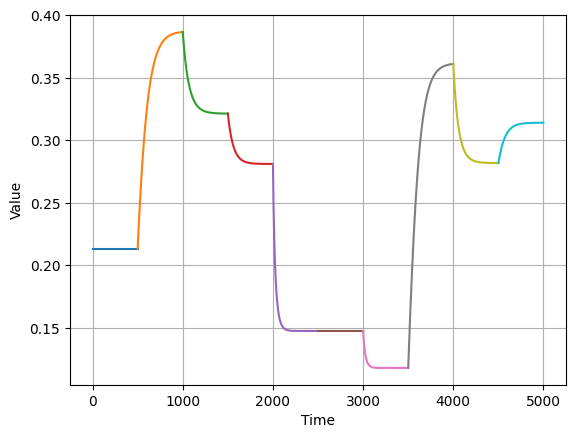

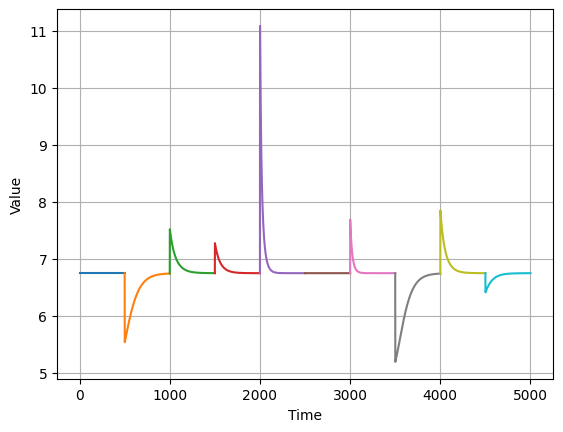

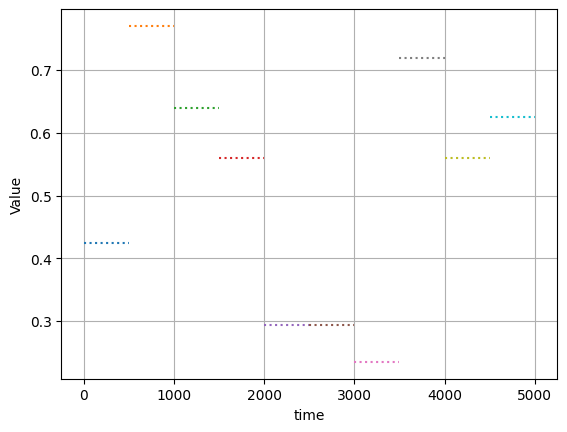

In [386]:
plt.figure("mass flow rate x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(massFlowrate[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("Plenum pressure x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(PlenumPressure[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("alpha x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(alpha_values[i]), linestyle=':')
plt.grid(True)
plt.xlabel('time') 
plt.ylabel('Value')


plt.show()


In [387]:
RNN_train = np.array(RNN_train)
RNN_test = np.array(RNN_test)
print(RNN_train.shape)
print(RNN_test.shape)

timestep = 4

X = []
y = []

x_test = []

for i in range(len(RNN_train[0][0])):
    X.append(RNN_train[:,:,i])
    if i == (len(RNN_train[0][0]) - 1):
        y.append(RNN_test[:, :2, 0])
    else:
        y.append(RNN_train[:,:2,i+1])
    x_test.append(RNN_test[:,:,i])


X = np.array(X)
print(X.shape)
y = np.array(y)

print(y.shape)

x_test = np.array(x_test)


(5, 3, 500)
(5, 3, 500)
(500, 5, 3)
(500, 5, 2)


In [388]:

model = keras.Sequential()
model.add(layers.Bidirectional(layers.SimpleRNN(50, input_shape=(timestep,3), return_sequences= True, activation='relu')))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2))

def lossCustom(y_true, y_pred):
    print(y_true.shape, y_pred)
    
    y_pred_flat = tf.reshape(y_pred, [-1])
    y_true_flat = tf.reshape(y_true, [-1])
    data_loss = tf.reduce_mean(tf.square(y_true_flat - y_pred_flat))
    return data_loss

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


history = model.fit(X,y,epochs = 300, verbose = 1)

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 16.5575   
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9718 
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2860 
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5970 
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1310 
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8586 
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7408 
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4837 
Epoch 9/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3567 
Epoch 10/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2452 
Epoch 11/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2734 
Epoch 12/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1042 
Epoch 13/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0278 
Epoch 14/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0116 
Epoch 15/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

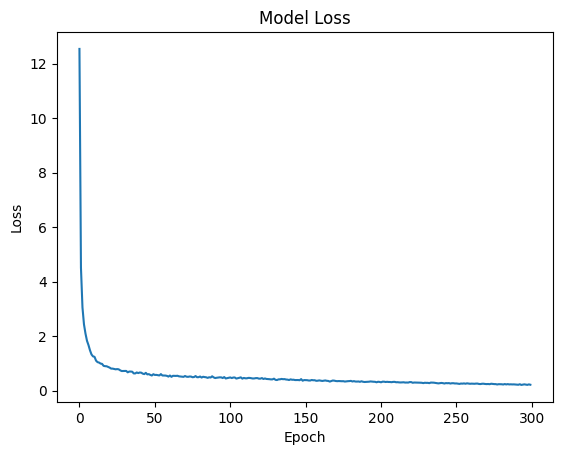

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[0.25960508 6.776836  ]
 [0.26811218 6.736881  ]
 [0.2674874  6.7372627 ]
 [0.26689798 6.7376704 ]
 [0.26634154 6.7381015 ]
 [0.26581597 6.7385516 ]
 [0.26531932 6.7390203 ]
 [0.26484975 6.7395053 ]
 [0.26440567 6.740004  ]
 [0.26398546 6.7405157 ]
 [0.26358774 6.7410383 ]
 [0.26321113 6.7415705 ]
 [0.26285446 6.742111  ]
 [0.26251656 6.7426586 ]
 [0.2621964  6.743212  ]
 [0.2618929  6.7437716 ]
 [0.26160526 6.744335  ]
 [0.2613325  6.7449026 ]
 [0.2610739  6.745473  ]
 [0.2608286  6.746045  ]
 [0.260596   6.7466183 ]
 [0.26037535 6.747193  ]
 [0.2601661  6.7477684 ]
 [0.25996763 6.7483435 ]
 [0.2597794  6.748919  ]
 [0.25960088 6.7494926 ]
 [0.25943157 6.750066  ]
 [0.25927103 6.7506375 ]
 [0.25911883 6.7512074 ]
 [0.25897455 6.751775  ]
 [0.2588378  6.75234   ]
 [0.2587082  6.7529035 ]
 [0.25858548 6.7534623 ]
 [0.25846925 6.7540207 ]
 [0.2583592  6.7545743 ]
 [0.25825506 6.755125  ]
 [0.25815654 6.7556725 ]
 [0.2580634  6.756216  ]
 [0.2579754

IndexError: index 2 is out of bounds for axis 1 with size 2

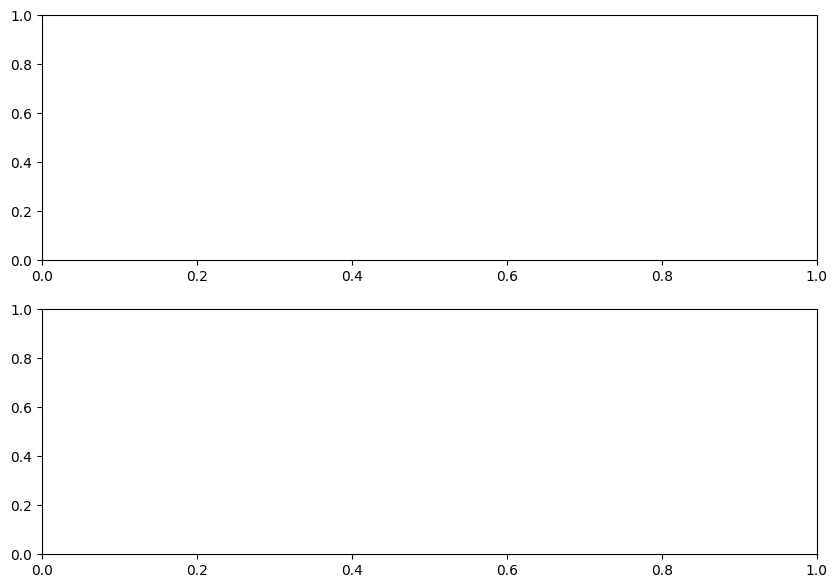

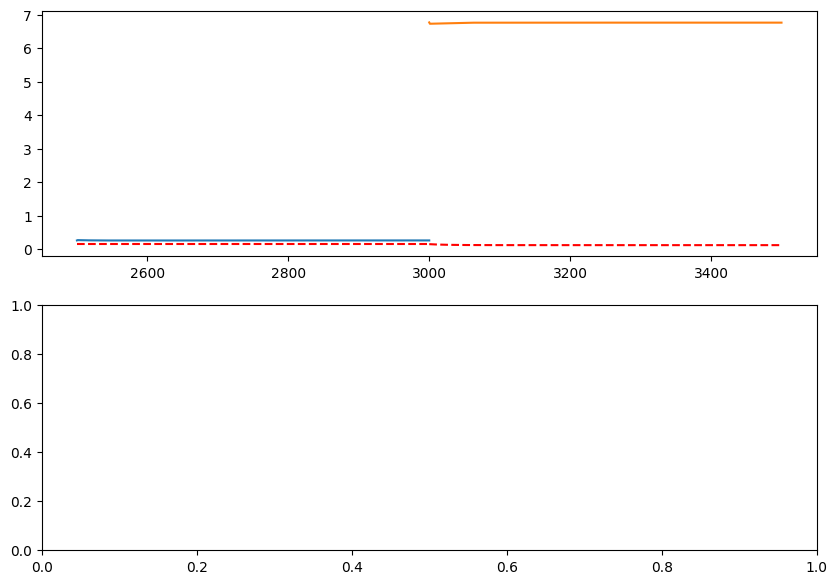

In [389]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Assuming X_new is the new data for prediction
prediction = model.predict(x_test)

# Extract mass and pressure from prediction
mass = prediction[:,:,0]
print(mass)
pressure = prediction[:, :,1]
print(pressure)

# Cria uma figura com subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

# Gráfico da mass FlowRate vs. Tempo
for i in range(5, 10):
    axs[0].plot(interval[i], np.squeeze(mass[:,i-5]))
    axs[0].plot(interval[i], np.squeeze(massFlowrate[i]), 'r--')
axs[0].grid(True)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mass Flow Rate')
axs[0].set_title('Mass Flow Rate vs Time')
axs[0].legend()

# Gráfico da Pressão do PlenumPressure vs. Tempo
for i in range(5, 10):
    axs[1].plot(interval[i], np.squeeze(pressure[:,i-5]))
    axs[1].plot(interval[i], np.squeeze(PlenumPressure[i]), 'r--')
axs[1].grid(True)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Plenum Pressure')
axs[1].set_title('Plenum Pressure vs Time')
axs[1].legend()

